In [35]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.geometry import Point
from sentence_transformers import SentenceTransformer, util
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss, accuracy_score, recall_score, f1_score, average_precision_score
from sklearn.model_selection import StratifiedKFold
from imblearn.metrics import geometric_mean_score
from sklearn.preprocessing import LabelEncoder

In [3]:
# merge the gentri label to the vectorization text
# use 'polygon' or 'wgs84_polygon', depend on what coordinate the label is
# load gentri label
lsoa_label = gpd.read_file("data/gentri_data/london_gentri_labeled_25.shp")
lsoa_label.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [4]:
stru_data = pd.read_csv("data/all_stru_data_added.csv")
print(lsoa_label.columns)

Index(['LSOA code', 'LSOA11NM', 'imd_score_', 'price_grow', 'high_price',
       'high_imd_i', 'gentri_cat', 'geometry'],
      dtype='object')


In [5]:
print(stru_data.columns)

Index(['LSOA Code', 'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
       'all_dwelling', 'shared_per', 'converted_per', 'level_4_pop',
       'level_4_per', 'prof_occ_count', 'prof_occ_per', 'pro_sale_2019',
       'sale_avg', 'single_per', 'less_10km_per'],
      dtype='object')


In [6]:
stru_data = stru_data.rename(columns={'LSOA Code': 'LSOA code'})
lsoa_label = lsoa_label.merge(stru_data, on= "LSOA code", how="left")

In [7]:
# use the wgs84_polygon to join the label with text
# read the text
text = pd.read_parquet("sbert_encoded_data.parquet")
print(text.columns)

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'sbert_374', 'sbert_375', 'sbert_376', 'sbert_377', 'sbert_378',
       'sbert_379', 'sbert_380', 'sbert_381', 'sbert_382', 'sbert_383'],
      dtype='object', length=401)


In [8]:
# turn polygon coordinate into shapely 
# make sure to drop the null geodata
text_valid = text[text['wgs84_polygon.coordinates'].notnull()].copy()
text_valid["geometry"] = text_valid["wgs84_polygon.coordinates"].apply(lambda coords: Polygon(coords[0]))
# creat GeoDataFrame， set WGS84 coordinate
gdf_text = gpd.GeoDataFrame(text_valid, geometry="geometry", crs="EPSG:4326")

In [9]:
# set to 27700
gdf_27700 = gdf_text.to_crs("EPSG:27700")

In [10]:
# joined = gpd.sjoin(gdf_27700, lsoa_label[["LSOA code", "geometry", "gentrified", "pop_growth_rate", 
#                                           "2019_final", "Index of M", 
#                                           "avg_den", "senior_per", "minority_per",
#                                           'all_dwelling', 'shared_per', 'converted_per',
#                                           'level_4_pop', 'level_4_per',
#                                           'prof_occ_count', 'prof_occ_per',
#                                           'sale_avg',
#                                           'single_per',
#                                           'less_10km_per']], 
#                                           how="left", predicate="within")

In [13]:
joined = gpd.sjoin(gdf_27700, lsoa_label[["LSOA code", "geometry", "gentri_cat", 
                                          "avg_den", "senior_per", "minority_per",
                                          'all_dwelling', 'shared_per', 'converted_per',
                                          'level_4_pop', 'level_4_per',
                                          'prof_occ_count', 'prof_occ_per',
                                          'sale_avg',
                                          'single_per',
                                          'less_10km_per']], 
                                          how="left", predicate="within")

In [15]:
# get the centroid of each polygon
gdf_27700["centroid"] = gdf_27700.geometry.centroid

In [16]:
# spatial join
joined_centroid = gpd.sjoin(gdf_27700.set_geometry("centroid"), lsoa_label[["LSOA code", "geometry", 
                                                                            "gentri_cat", 
                                                                            "avg_den", "senior_per", "minority_per"]],
                                                                            how="left",predicate="within")

In [17]:
joined_cleaned = joined_centroid[joined_centroid["gentri_cat"].notna()].copy()
joined_cleaned.columns

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'sbert_382', 'sbert_383', 'geometry', 'centroid', 'index_right',
       'LSOA code', 'gentri_cat', 'avg_den', 'senior_per', 'minority_per'],
      dtype='object', length=409)

In [18]:
lsoa_counts = joined_cleaned.groupby('LSOA code').size().reset_index(name='application_count')

<Axes: >

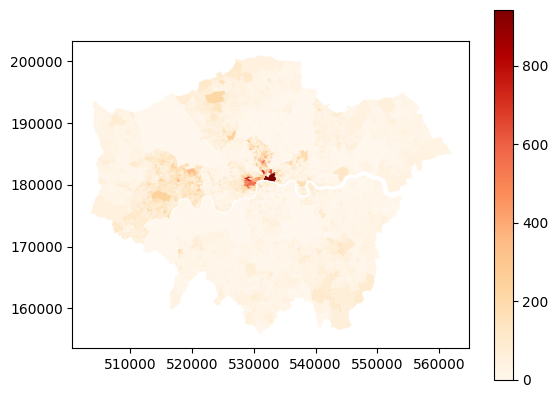

In [19]:
# gdf_lsoa: 是你读取的 LSOA 边界数据
lsoa_label = lsoa_label.merge(lsoa_counts, on='LSOA code', how='left')
lsoa_label['application_count'] = lsoa_label['application_count'].fillna(0).astype(int)

# 地图可视化
lsoa_label.plot(column='application_count', cmap='OrRd', legend=True)

In [20]:
# import numpy as np

# # 提取嵌入矩阵（句子向量）
# sbert_cols = [col for col in joined_cleaned.columns if col.startswith("sbert_")]
# sentence_embeddings = joined_cleaned[sbert_cols].values  # shape = (n_sentences, 384)

# # 提取 meta 信息
# sentence_df = joined_cleaned[["LSOA code", "description"]].reset_index(drop=True)

In [21]:
# anchor_dict = {
#     "residential": ["flat conversion", "refurbishment", "rear extension", 
#                     "erection of storey", "demolition of exsiting rear", "alterations",
#                     "replacement", "installation", "windows"],
#     "commercial": ["coffee shop", "illuminated sign", "retail upgrade", 
#                    "change use", "fascia", "digital screen"],
#     "green": ["park improvement", "landscaping", "tree planting"],
#     "cultural": ["artist studios", "cultural space", "gallery conversion", "garage"],
#     "infrustructure": ["station upgrade", "utilities improvement", "internally illuminated", 
#                        "cycle", "parking", "lighting repalcement", "antennas", "public"]
# }
# sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [22]:
# from sklearn.preprocessing import normalize

# def compute_multi_anchor_group_scores(
#     sentence_df,
#     sentence_embeddings,
#     anchor_groups,
#     groupby_col="LSOA code",
#     agg="mean",
#     normalize_emb=True
# ):
#     """
#     对每类 anchor 关键词组计算句子相似度，并在 groupby 层级聚合

#     Parameters:
#     - sentence_df: 包含 groupby_col 的 DataFrame，每行对应一个句子
#     - sentence_embeddings: numpy array，shape=(n_sentences, 384)
#     - anchor_groups: dict[str, list[str]]，如 {"density": [...], "luxury": [...]}
#     - groupby_col: str，默认 "LSOA code"
#     - agg: str，"mean" or "sum"
#     - normalize_emb: bool，是否归一化句子向量（建议为 True）

#     Returns:
#     - merged_df: 每个 groupby 单位的所有 anchor 类得分（一个特征表）
#     """
#     model = SentenceTransformer("all-MiniLM-L6-v2")

#     if hasattr(sentence_embeddings, "numpy"):
#         sentence_vecs = sentence_embeddings.numpy()
#     else:
#         sentence_vecs = sentence_embeddings

#     if normalize_emb:
#         sentence_vecs = normalize(sentence_vecs)

#     sentence_vecs = sentence_vecs.astype("float32")

#     all_group_scores = []

#     for group_name, anchor_phrases in tqdm(anchor_groups.items(), desc="Processing anchor groups"):
#         # 编码当前组 anchor 短语
#         anchor_vecs = model.encode(anchor_phrases, normalize_embeddings=True)

#         # 计算相似度：每个句子 vs 当前组所有 anchor
#         similarities = util.cos_sim(sentence_vecs, anchor_vecs).numpy()
#         max_scores = similarities.max(axis=1)

#         temp_df = sentence_df.copy()
#         temp_df[f"{group_name}_score"] = max_scores

#         # 聚合
#         if agg == "mean":
#             lsoa_scores = temp_df.groupby(groupby_col)[f"{group_name}_score"].mean().reset_index()
#         elif agg == "sum":
#             lsoa_scores = temp_df.groupby(groupby_col)[f"{group_name}_score"].sum().reset_index()
#         else:
#             raise ValueError("agg must be 'mean' or 'sum'")

#         all_group_scores.append(lsoa_scores)

#     # 合并所有得分
#     merged_df = all_group_scores[0]
#     for df in all_group_scores[1:]:
#         merged_df = merged_df.merge(df, on=groupby_col, how="outer")

#     merged_df.fillna(0, inplace=True)
#     return merged_df

In [23]:
# lsoa_scores = compute_multi_anchor_group_scores(
#     sentence_df=joined_cleaned[["LSOA code", "description"]],
#     sentence_embeddings=sentence_embeddings,
#     anchor_groups=anchor_dict,
#     groupby_col="LSOA code",
#     agg="mean"
# )

In [24]:
# lsoa_scores.to_csv("lsoa_anchor_scores.csv", index=False)

In [25]:
lsoa_scores = pd.read_csv("lsoa_anchor_scores.csv")

In [26]:
# 合并进 final_df
final_df = lsoa_label.merge(lsoa_scores, on="LSOA code", how="left")
final_df.fillna(0, inplace=True)

In [27]:
final_df['total_score'] = final_df[
    ['residential_score', 'commercial_score', 'green_score',
     'cultural_score', 'infrustructure_score']].sum(axis=1)

In [28]:
df_poi = pd.read_csv("data/poi_15_19.csv")
print(df_poi.head(5))

   LSOA code  shop_increase  metro_increase  bus_increase
0  E01000001            2.0            -1.0           1.0
1  E01000002            0.0             1.0          -6.0
2  E01000003            8.0             0.0           0.0
3  E01000005            6.0             1.0          -1.0
4  E01000006            0.0             0.0           0.0


In [29]:
final_df = final_df.merge(df_poi[['LSOA code','shop_increase','metro_increase','bus_increase']], on="LSOA code", how="left")

In [30]:
print(final_df.columns)

Index(['LSOA code', 'LSOA11NM', 'imd_score_', 'price_grow', 'high_price',
       'high_imd_i', 'gentri_cat', 'geometry', 'pop_growth_rate', 'avg_den',
       'senior_per', 'minority_per', 'all_dwelling', 'shared_per',
       'converted_per', 'level_4_pop', 'level_4_per', 'prof_occ_count',
       'prof_occ_per', 'pro_sale_2019', 'sale_avg', 'single_per',
       'less_10km_per', 'application_count', 'residential_score',
       'commercial_score', 'green_score', 'cultural_score',
       'infrustructure_score', 'total_score', 'shop_increase',
       'metro_increase', 'bus_increase'],
      dtype='object')


In [31]:
features = ['pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
            'all_dwelling','converted_per', 
            'level_4_pop',
            'prof_occ_count',
            'pro_sale_2019', 'sale_avg',
            'single_per',
            'shop_increase','metro_increase','bus_increase',
            'residential_score', 'commercial_score', 'green_score', 'cultural_score', 'infrustructure_score', 
            'application_count','total_score']
base = ['pop_growth_rate', 'avg_den', 'senior_per','minority_per',
        'all_dwelling','converted_per',
        'level_4_pop',
        'prof_occ_count',
        'pro_sale_2019', 'sale_avg',
        'single_per',
        'shop_increase','metro_increase','bus_increase']
features_text = ['residential_score', 'commercial_score', 'green_score', 'cultural_score', 'infrustructure_score', 'application_count','total_score']

C:\Users\hp\AppData\Local\Temp\ipykernel_29808\2791517886.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hp\AppData\Local\Temp\ipykernel_29808\2791517886.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hp\AppData\Local\Temp\ipykernel_29808\2791517886.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hp\AppData\Local\Temp\ipykernel_29808\2791517886.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `leg

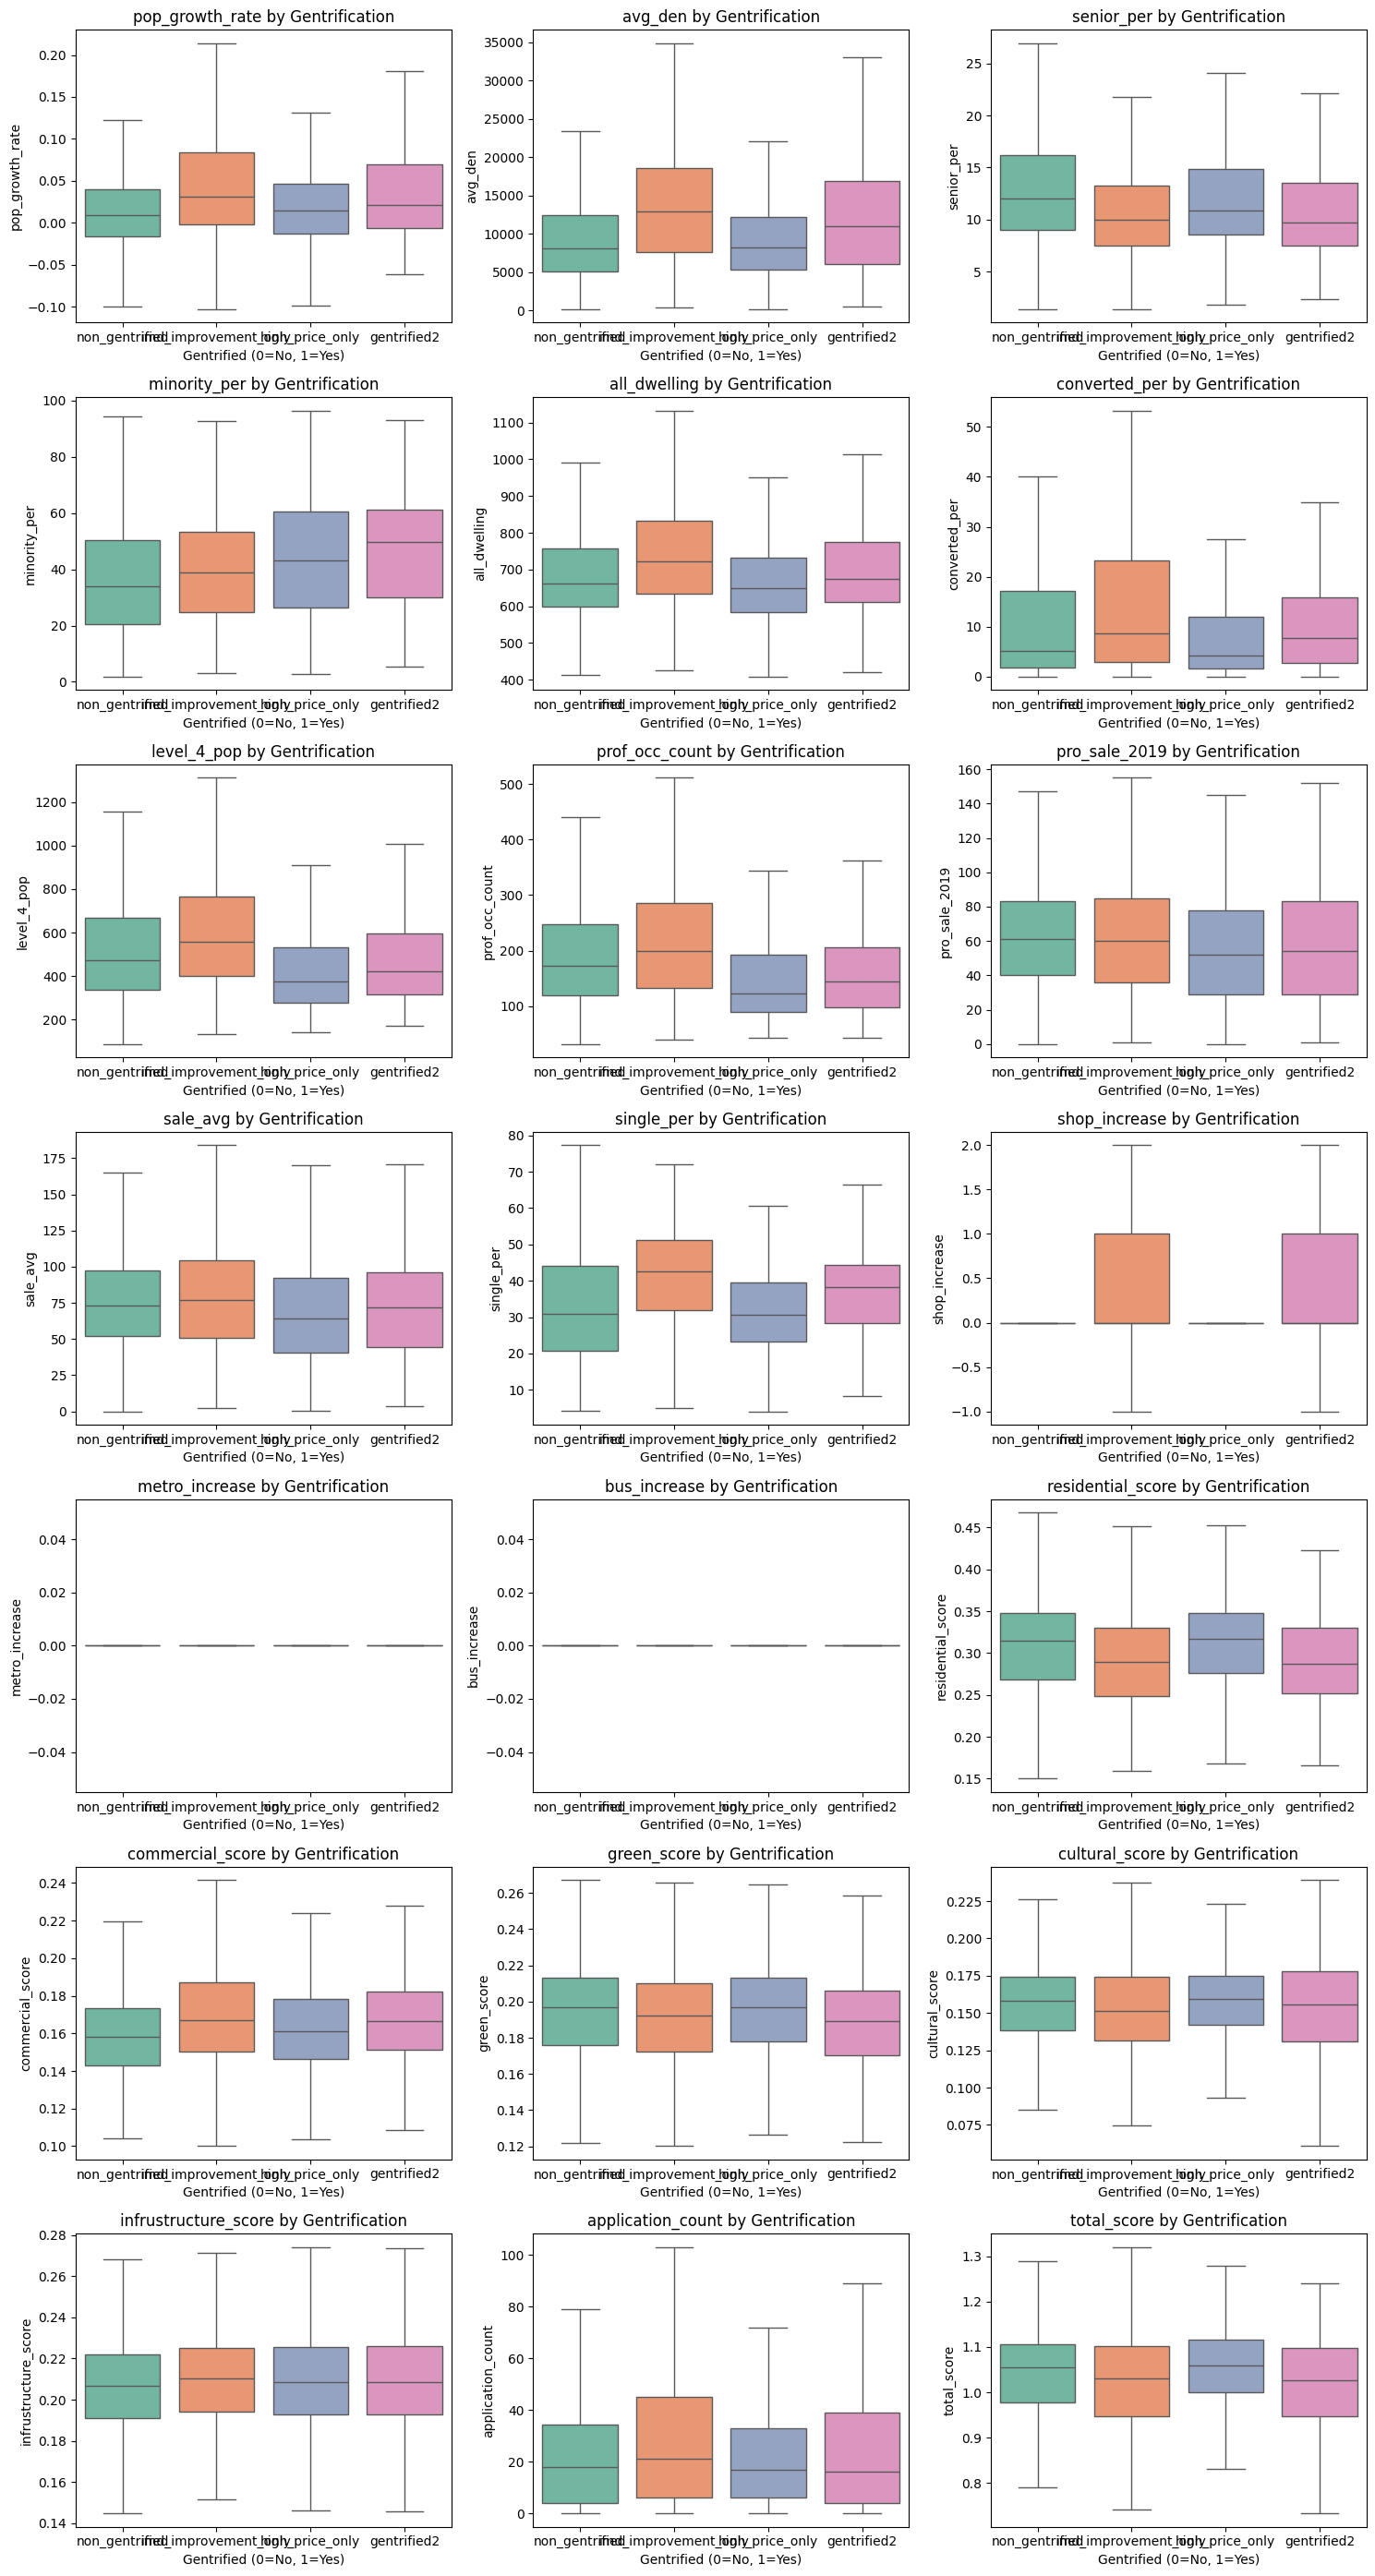

In [33]:

# 开始绘图
n_cols = 3  # 每行显示几个图
n_rows = -(-len(features) // n_cols)  # 自动计算行数（向上取整）

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(
        data=final_df,
        x='gentri_cat',
        y=feature,
        ax=axes[i],
        palette='Set2',
        showfliers=False  # 不显示离群点，图更清晰
    )
    axes[i].set_title(f'{feature} by Gentrification')
    axes[i].set_xlabel('Gentrified (0=No, 1=Yes)')
    axes[i].set_ylabel(feature)

# 去掉多余子图
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [38]:
# 特征和标签
X = final_df[features]
le = LabelEncoder()
y = pd.Series(le.fit_transform(final_df['gentri_cat']))  # 标签编码为整数
print("Label encoding mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# 初始化评估器
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
acc_scores, logloss_scores, macro_f1s, macro_recalls = [], [], [], []

# 每类指标记录
from collections import defaultdict
per_class_f1 = defaultdict(list)
per_class_recall = defaultdict(list)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBClassifier(
        random_state=42,
        objective='multi:softprob',
        num_class=4,
        eval_metric='mlogloss',
        max_delta_step=1,
        learning_rate=0.05,
        n_estimators=200
    )

    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)
    y_pred = np.argmax(y_proba, axis=1)

    # Overall 评估
    acc_scores.append(accuracy_score(y_test, y_pred))
    logloss_scores.append(log_loss(y_test, y_proba))
    macro_f1s.append(f1_score(y_test, y_pred, average='macro'))
    macro_recalls.append(recall_score(y_test, y_pred, average='macro'))

    # 每类评估
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    for label in ['0', '1', '2', '3']:  # 注意这里是字符串类型
        per_class_f1[label].append(report[label]['f1-score'])
        per_class_recall[label].append(report[label]['recall'])

# 汇总平均结果
print("\nMulticlass Cross-Validation Summary:")
print(f"Average Accuracy:     {np.mean(acc_scores):.4f}")
print(f"Average Log-loss:     {np.mean(logloss_scores):.4f}")
print(f"Average Macro F1:     {np.mean(macro_f1s):.4f}")
print(f"Average Macro Recall: {np.mean(macro_recalls):.4f}")

# 打印每类的平均结果
print("\nPer-Class F1 & Recall (averaged across folds):")
for idx, label in enumerate(le.classes_):  # 显示原始类名
    avg_f1 = np.mean(per_class_f1[str(idx)])
    avg_rec = np.mean(per_class_recall[str(idx)])
    print(f"{label} - Avg F1: {avg_f1:.3f} | Avg Recall: {avg_rec:.3f}")

Label encoding mapping: {'gentrified2': np.int64(0), 'high_price_only': np.int64(1), 'imd_improvement_only': np.int64(2), 'non_gentrified': np.int64(3)}

Multiclass Cross-Validation Summary:
Average Accuracy:     0.5797
Average Log-loss:     1.0349
Average Macro F1:     0.3550
Average Macro Recall: 0.3491

Per-Class F1 & Recall (averaged across folds):
gentrified2 - Avg F1: 0.071 | Avg Recall: 0.041
high_price_only - Avg F1: 0.243 | Avg Recall: 0.176
imd_improvement_only - Avg F1: 0.386 | Avg Recall: 0.309
non_gentrified - Avg F1: 0.720 | Avg Recall: 0.870


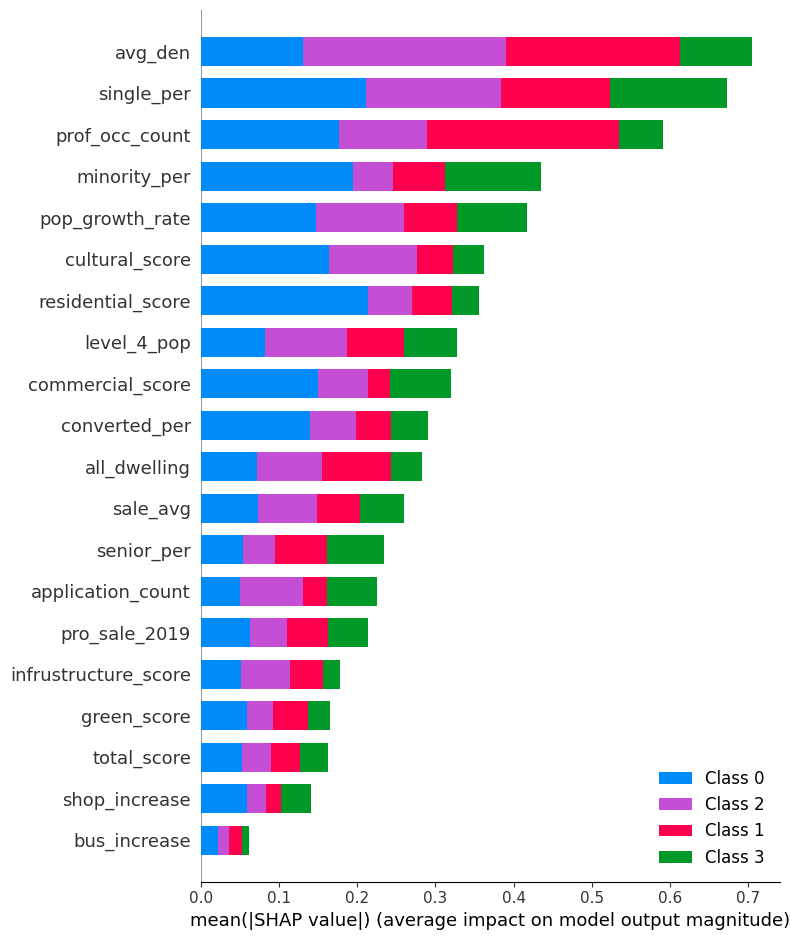

In [40]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

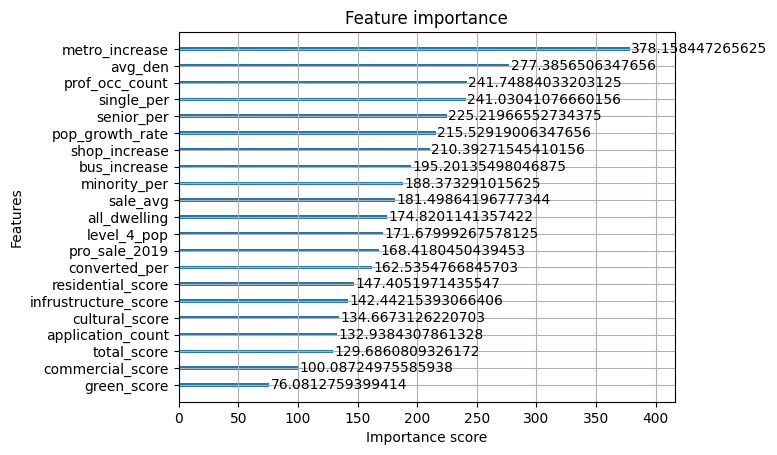

In [41]:
from xgboost import plot_importance
plot_importance(model, importance_type='cover')